# Brasil

- análise de uma cultura agrícola (dados de 2017)
- diferentes níveis de agregação
- remoção de ilhas
- uso da função *dissolve* para modificar o conjunto de dados

# Produção de uma cultura no Brasil

In [ ]:
!pip install geopandas shapely mapclassify libpysal splot esda pysal
!pip install --upgrade pyshp
!pip install --upgrade descartes

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# links com arquivos úteis
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/'
link_p = 'https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/'

Quantidade produzida

In [2]:
# ler dados de interesse
dados = pd.read_csv('https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/qtde-cod-18-br.csv', encoding='utf-8')
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/br.json'
geodf = gp.read_file(link)   # ler shapefile

# mesclar shapefile com dataframe usando a coluna mun
geodf.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True)  # mudar nome da coluna com cód. para 'mun'
geodf['mun'] = geodf.mun.astype(int)  # transformar códigos em inteiros
br = pd.merge(geodf, dados, on='mun', suffixes=('', '_y'))  # mesclar o dataframe e o shapefile em um objeto
br = br.loc[:, br.columns != 'NM_MUNICIP']  # tirar a coluna NM_MUNICIP

In [3]:
br.head()

,mun,geometry,nome_mun,uf,nome_uf,rm,meso,nome_meso,micro,nome_micro,...,manga,milho,soja,sorgo,tangerina,tomate,trigo,leite,ovos,mel
0,1100015,"POLYGON ((-62.19465 -11.82746, -62.17332 -11.8...",Alta Floresta D'Oeste,11,Rondônia,NaN,1102,Leste Rondoniense,11006,Cacoal,...,0,15667,1350,0,0,0,0,9024,271,1700
1,1100023,"POLYGON ((-62.53648 -9.73222, -62.49559 -9.772...",Ariquemes,11,Rondônia,NaN,1102,Leste Rondoniense,11003,Ariquemes,...,0,3330,10959,0,0,0,0,14497,445,1000
2,1100031,"POLYGON ((-60.37075 -13.36363, -60.37959 -13.3...",Cabixi,11,Rondônia,NaN,1102,Leste Rondoniense,11008,Colorado do Oeste,...,0,81690,70320,0,60,90,0,8311,151,680
3,1100049,"POLYGON ((-61.00080 -11.29737, -61.00302 -11.4...",Cacoal,11,Rondônia,NaN,1102,Leste Rondoniense,11006,Cacoal,...,0,3616,1710,0,170,90,0,21814,1645,8500
4,1100056,"POLYGON ((-61.49976 -13.00525, -61.43437 -13.0...",Cerejeiras,11,Rondônia,NaN,1102,Leste Rondoniense,11008,Colorado do Oeste,...,0,105760,98000,0,0,900,0,4772,93,4400


In [4]:
br.columns

Index(['mun', 'geometry', 'nome_mun', 'uf', 'nome_uf', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'cod_rgi', 'nome_rgi', 'cod_rgint',
       'nome_rgint', 'codmun6', 'regiao', 'nome_regiao', 'area', 'algodao_arb',
       'algodao_herb', 'banana', 'batata', 'cafe_arab', 'cana', 'feijao',
       'laranja', 'limao', 'manga', 'milho', 'soja', 'sorgo', 'tangerina',
       'tomate', 'trigo', 'leite', 'ovos', 'mel'],
      dtype='object')

In [5]:
variavel = 'milho'      # escolher a variável e colocar entre aspas

In [6]:
# resumo estatístico
br[variavel].describe()

count    5.558000e+03
mean     1.757560e+04
std      9.417556e+04
min      0.000000e+00
25%      9.000000e+01
50%      8.000000e+02
75%      6.877500e+03
max      3.841566e+06
Name: milho, dtype: float64

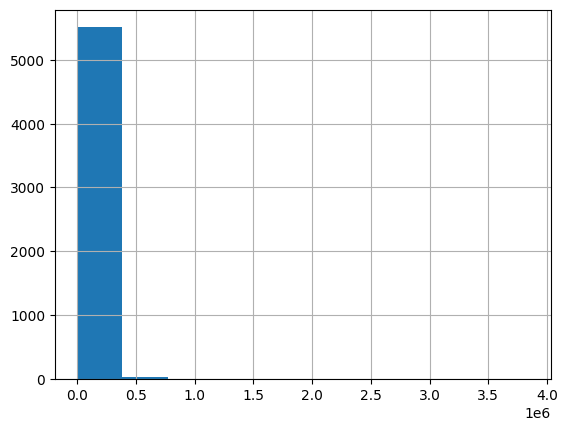

In [7]:
# histograma
br[variavel].hist();

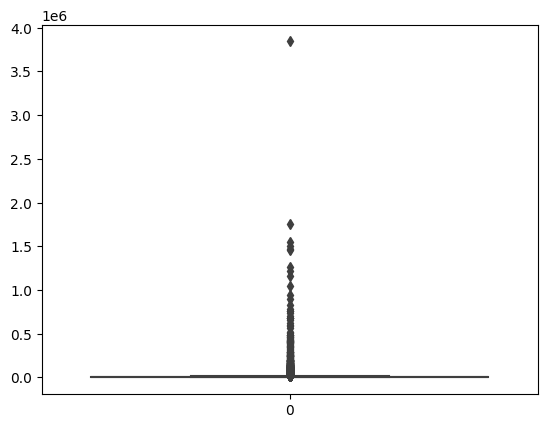

In [8]:
# boxplot
sns.boxplot(br[variavel], orient='v');

In [9]:
# visualizar os municípios em ordem decrescente (ou crescente)
br.sort_values(variavel, ascending=False)[['nome_mun', 'nome_uf', 'nome_meso', variavel]].head(10)

,nome_mun,nome_uf,nome_meso,milho
5295,Sorriso,Mato Grosso,Norte Mato-grossense,3841566
5247,Nova Mutum,Mato Grosso,Norte Mato-grossense,1751821
5508,Rio Verde,Goiás,Sul Goiano,1551600
5438,Jataí,Goiás,Sul Goiano,1506000
5191,Campo Novo do Parecis,Mato Grosso,Norte Mato-grossense,1472104
5249,Nova Ubiratã,Mato Grosso,Norte Mato-grossense,1456900
5232,Lucas do Rio Verde,Mato Grosso,Norte Mato-grossense,1262010
5141,Maracaju,Mato Grosso do Sul,Sudoeste de Mato Grosso do Sul,1218000
5292,Sapezal,Mato Grosso,Norte Mato-grossense,1160329
5210,Diamantino,Mato Grosso,Norte Mato-grossense,1041900


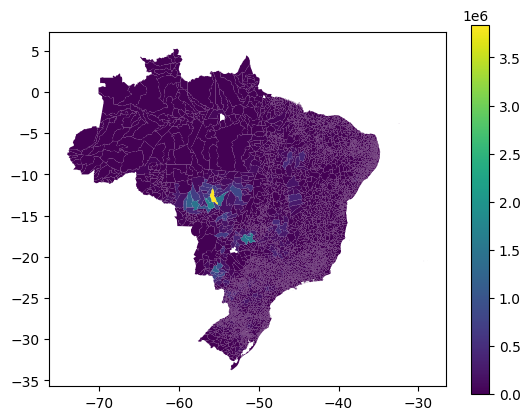

In [10]:
# mapa temático - simples
br.plot(variavel, legend=True);

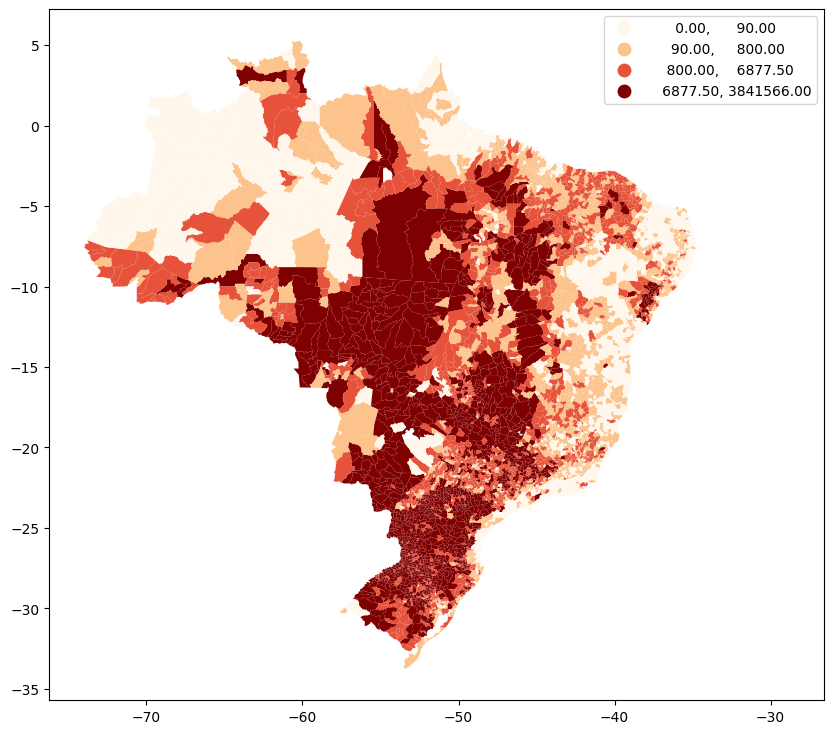

In [11]:
# mapa temático - quantiles
br.plot(column=variavel, figsize=(10, 10), scheme='Quantiles', cmap='OrRd', legend=True, k=4);

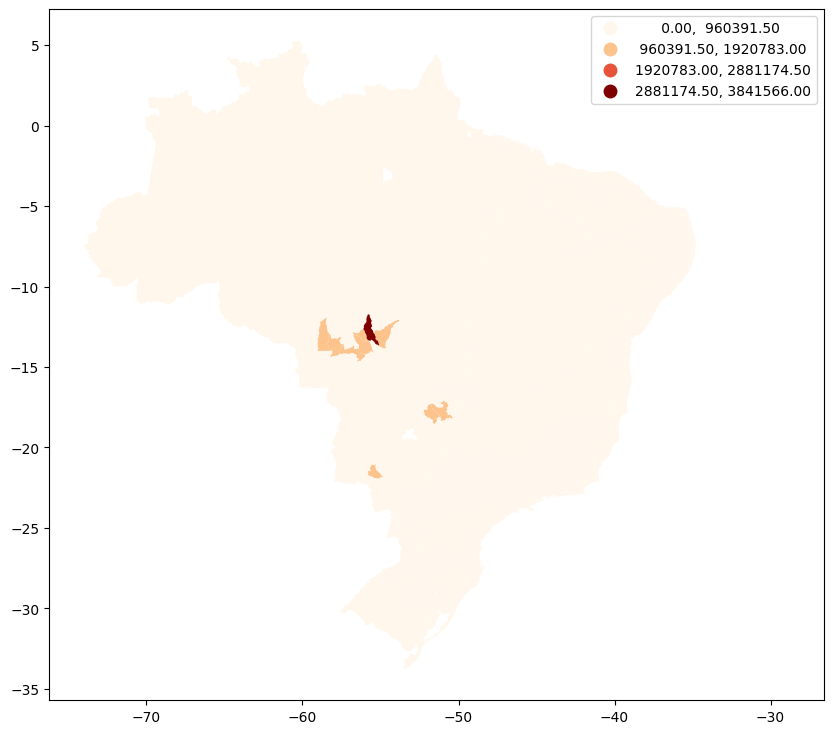

In [12]:
# mapa temático - equal_interval
br.plot(column=variavel, figsize=(10, 10), scheme='Equal_Interval', cmap='OrRd', legend=True, k=4);

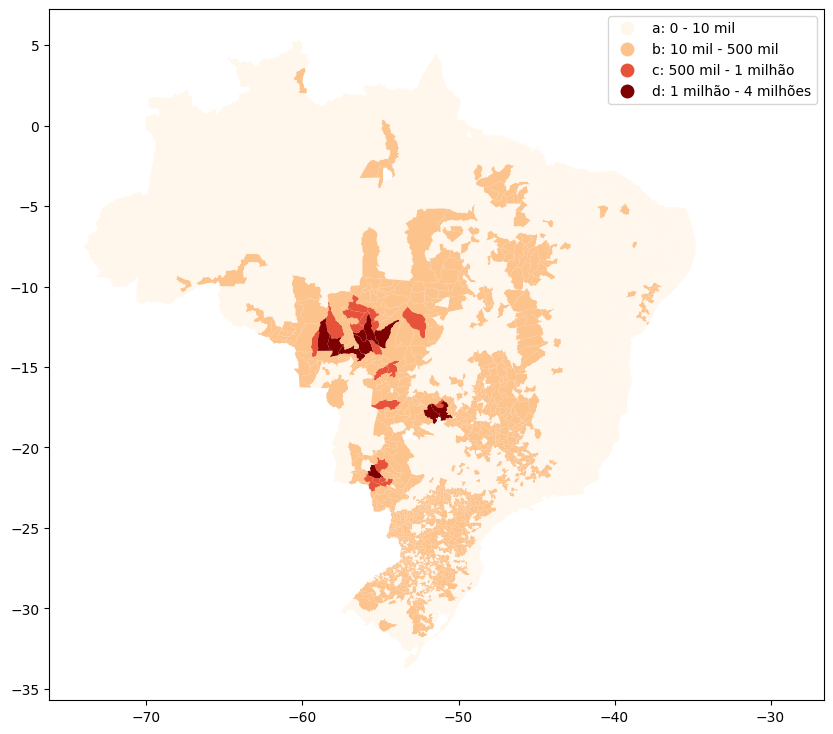

In [13]:
# intervalos de valores definidos pelo usuário
referencia = [10000, 500000, 1000000, 4000000]     # valores de referência considera 'abaixo que'
labels = ['a: 0 - 10 mil', 'b: 10 mil - 500 mil', 'c: 500 mil - 1 milhão', 'd: 1 milhão - 4 milhões']  # letras por causa de ordenação alfabética
valores = br[variavel]
quantis = mc.UserDefined(valores, referencia)
cl = [labels[i] for i in quantis.yb]
df = br.assign(cl=cl)
df.cl = pd.Categorical(df.cl, ordered=True, categories=labels)
df.plot(column='cl', figsize=(10, 10), cmap='OrRd', legend=True);

In [14]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(br)
w.transform = 'r'
# calcular I de Moran global para a variável escolhida
y = br[variavel].values
moran = Moran(y, w)
moran.I

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_17380\2353568294.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(br)
c:\Users\Luan Lima\AppData\Local\Programs\Python\Python310\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1523, 3493.
  warnings.warn(message)


('WARNING: ', 1523, ' is an island (no neighbors)')
('WARNING: ', 3493, ' is an island (no neighbors)')


0.5332596574341079

In [15]:
br.shape

(5558, 37)

In [16]:
# ilhas
br.query('index == 1523 or index == 3493')

,mun,geometry,nome_mun,uf,nome_uf,rm,meso,nome_meso,micro,nome_micro,...,manga,milho,soja,sorgo,tangerina,tomate,trigo,leite,ovos,mel
1523,2605459,"POLYGON ((-32.39705 -3.83294, -32.39114 -3.851...",Fernando de Noronha,26,Pernambuco,NaN,2605,Metropolitana de Recife,26019,Fernando de Noronha,...,0,0,0,0,0,0,0,14,0,0
3493,3520400,"MULTIPOLYGON (((-45.30051 -23.92276, -45.30092...",Ilhabela,35,São Paulo,RM do Vale do Paraíba e Litoral Norte,3513,Vale do Paraíba Paulista,35054,Caraguatatuba,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# retirar ilhas
br = br.drop([1523, 3493]) # retira F. Noronha e Ilhabela

O sistema de referência WGS84 (*World Geodetic System*, 1984) é bastante utilizado em sistemas GPS e aplicativos da Google, por exemplo). A Google utiliza informações espaciais que são armazenadas como WGS84 e projetadas para WGS84 (EPSG: 4326) para o Google Earth e Pseudo Mercator (EPSG: 3857) para o Google Maps.

Fonte: https://geopandas.org/en/stable/docs/user_guide/projections.html



In [18]:
# ajustando o sistema de referência de coordenadas
br = br.to_crs(epsg=3395)
br.shape

(5556, 37)

In [19]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(br)
w.transform = 'r'
# calcular I de Moran global para a variável escolhida
y = br[variavel].values
moran = Moran(y, w)
moran.I

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_17380\2353568294.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(br)


0.5330720497628445

In [20]:
# valor-p   nível de significância: 0,05
moran.p_sim

0.001

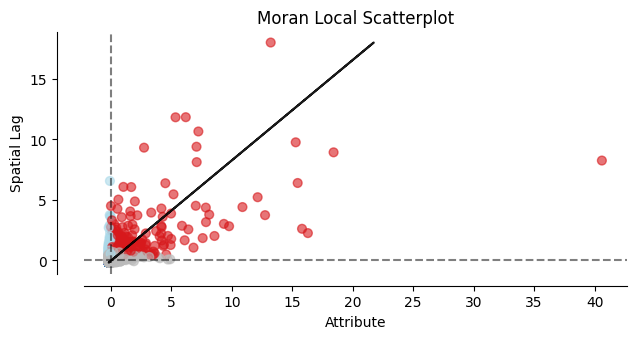

In [21]:
# só o diagrama de dispersão
moran_loc = Moran_Local(y, w)
moran_scatterplot(moran_loc, p=0.05);

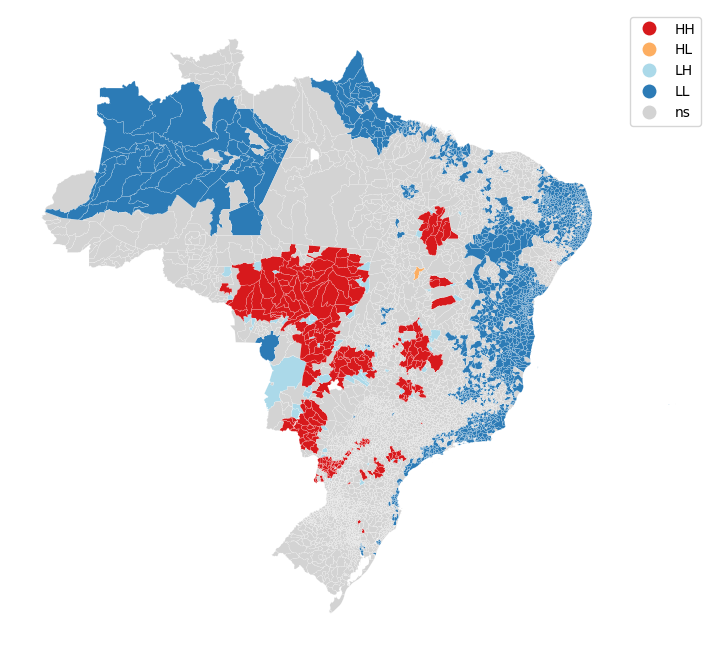

In [22]:
# mapa LISA
lisa_cluster(moran_loc, br, p=0.05, figsize = (9,9));

# Escolher partes do Brasil:

Unir estados para formar as regiões do Brasil.

In [ ]:
br.nome_uf.unique()

In [ ]:
SE = br.query('nome_uf == ["Minas Gerais", "São Paulo", "Rio de Janeiro", "Espírito Santo"]')

In [ ]:
SE.shape

In [ ]:
SE.plot();

In [ ]:
# mapa temático - quantiles
SE.plot(column=variavel, figsize=(10, 10), scheme='Quantiles', cmap='OrRd', legend=True, k=4);

In [ ]:
# resumo estatístico - para auxiliar na construção dos intervalos
SE[variavel].describe()

In [ ]:
# intervalos de valores definidos pelo usuário
referencia = [100, 7000, 3480000]     # valores de referência considera 'abaixo que'
labels = ['a: 0 - 100', 'b: 100 - 7 mil', 'c: 7 mil - 348 mil']  # letras por causa de ordenação alfabética
valores = SE[variavel]
quantis = mc.UserDefined(valores, referencia)
cl = [labels[i] for i in quantis.yb]
df = SE.assign(cl=cl)
df.cl = pd.Categorical(df.cl, ordered=True, categories=labels)
df.plot(column='cl', figsize=(10, 10), cmap='OrRd', legend=True);

# Tarefa 1:

Eu escolhi unir os estados da região Sudeste. Para a mesma variável utilizada por mim:

- escolha estados de outra região do Brasil
- obter o mapa temático por quantis
- obter o mapa temático definido pelo usuário, da forma que for mais adequada para a região escolhida por você (escolha quantos intervalos quiser e faça os ajustes necessários nos valores)

# Diferentes níveis de agregação:

Dividir em microrregiões do Brasil

In [ ]:
# usando a função buffer
br['geometry'] = br.geometry.buffer(0)

In [ ]:
# agrupar municípios em microrregiões
# somando os valores da variável para os municípios contidos em cada microrregião
micros = br.dissolve(by=['micro', 'nome_micro', 'nome_uf'], aggfunc='sum')
micros.head(3)

In [ ]:
micros.shape

In [ ]:
# reiniciar índices e retirar as colunas que não serão usadas
micros = micros.reset_index()
retirar = ['mun', 'uf', 'meso', 'cod_rgi', 'cod_rgint', 'codmun6', 'regiao', 'area']
micros = micros.drop(retirar, axis=1)
micros.head(3)

In [ ]:
micros = micros.to_crs(epsg=3395)

In [ ]:
# resumo estatístico
micros[variavel].describe()

In [ ]:
micros[variavel].hist();

In [ ]:
# boxplot
sns.boxplot(micros[variavel], orient='v');

In [ ]:
# visualizar as microrregiões em ordem decrescente (ou crescente)
micros.sort_values(variavel, ascending=False)[['nome_micro', 'nome_uf', variavel]].head(10)

In [ ]:
# mapa simples
micros.plot();

In [ ]:
# mapa temático - quantiles
micros.plot(column=variavel, figsize=(10, 10), scheme='Quantiles', cmap='OrRd', legend=True, k=4);

In [ ]:
# mapa temático - equal_interval
micros.plot(column=variavel, figsize=(10, 10), scheme='Equal_Interval', cmap='OrRd', legend=True, k=4);

In [ ]:
# mapa temático - fisher_jenks
micros.plot(column=variavel, figsize=(10, 10), scheme='fisher_jenks', cmap='OrRd', legend=True, k=4);

In [ ]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(micros)
w.transform = 'r'
# calcular I de Moran global para a variável escolhida
y = micros[variavel].values
moran = Moran(y, w)
moran.I

In [ ]:
# valor-p
moran.p_sim

In [ ]:
# mapa LISA
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, micros, p=0.05, figsize = (9,9));

In [ ]:
# mapa LISA com nomes dos significativos
fig, ax = plt.subplots(1, figsize=(20, 20))
lisa_cluster(moran_loc, micros, p=0.05, ax=ax, figsize = (9,9));
sig = moran_loc.p_sim < 0.05
posicoes = np.where(sig)
escolhidos = micros.iloc[posicoes[0]]
for j in escolhidos.index:
    ax.text(escolhidos.geometry.centroid[j].coords[0][0], escolhidos.geometry.centroid[j].coords[0][1],
         escolhidos.nome_micro[j],
         fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# Tarefa 2

Eu utilizei o nível de agregação microrregiões para os dados do Brasil. Usando a mesma variável já utilizada, escolha outro nível de agregação (mesorregiões, regiões imediatas, regiões intermediárias ou mesmo estados) e faça a análise completa:

- obtenha o mapa temático que você achar mais adequado (quantis, intervalos iguais, fisher-jenks ou definido por você) e ANALISE (apontando como estão distribuídos os valores no território brasileiro)
- obtenha o valor do *I* de Moran e valor-*p* e ANALISE (o valor do *I* é significativo? O que isso quer dizer? Qual a interpretação prática para a variável em questão?)
- obtenha o mapa LISA com os nomes das observações significativas e ANALISE (apontando quais foram os *clusters* espaciais, *outliers* espaciais)



# Tarefa 3

Compare suas conclusões obtidas na tarefa 2 (com o nível de agregação escolhido por você) com o que foi obtido por mim para as microrregiões:

- há semelhanças?
- há diferenças?
- aponte o que notou de interessante ao comparar os dois níveis de agragação (microrregiões *versus* nível escolhido por você)

Digite aqui sua análise da tarefa 3.


